In [2]:
import warnings
warnings.filterwarnings('ignore')

from sigpyproc.readers import FilReader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import dates
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.visualization import ImageNormalize, PercentileInterval

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# print(plt.get_backend())
path = '/home/mnedal/data/ilofar'

In [5]:
stokes = 'I'
filename = f'{path}/realta_ilofar_stokes{stokes}_20240514T1635.fil'

In [6]:
a = FilReader(filename) # header
header = a.header.to_dict()

In [7]:
[x for x in dir(a) if not x.startswith('_')]

['apply_channel_mask',
 'bandpass',
 'bitsinfo',
 'chan_stats',
 'chan_stride',
 'clean_rfi',
 'collapse',
 'compute_stats',
 'compute_stats_basic',
 'dedisperse',
 'downsample',
 'extract_bands',
 'extract_chans',
 'extract_samps',
 'filename',
 'fold',
 'header',
 'invert_freq',
 'logger',
 'read_block',
 'read_chan',
 'read_dedisp_block',
 'read_plan',
 'remove_zerodm',
 'requantize',
 'samp_stride',
 'subband']

In [8]:
header

{'filename': '/home/mnedal/data/ilofar/realta_ilofar_stokesI_20240514T1635.fil',
 'data_type': 'filterbank',
 'nchans': 488,
 'foff': -0.1953125,
 'fch1': 200.0,
 'nbits': 32,
 'tsamp': 0.00131072,
 'tstart': 60444.690972213044,
 'nsamples': 3433227,
 'nifs': 1,
 'coord': <SkyCoord (ICRS): (ra, dec) in deg
     (0., 0.)>,
 'azimuth': <Angle 235.90465428 deg>,
 'zenith': <Angle 133.53284027 deg>,
 'telescope': 'MeerKAT',
 'backend': 'FAKE',
 'source': 'Sun357',
 'frame': 'topocentric',
 'ibeam': 0,
 'nbeams': 0,
 'dm': 0,
 'period': 0,
 'accel': 0,
 'signed': False,
 'rawdatafile': 'unknown',
 'stream_info': {'entries': [{'filename': '/home/mnedal/data/ilofar/realta_ilofar_stokesI_20240514T1635.fil',
    'hdrlen': 347,
    'datalen': 6701659104,
    'nsamples': 3433227,
    'tstart': 60444.690972213044,
    'tsamp': 0.00131072}]},
 'basename': 'realta_ilofar_stokesI_20240514T1635',
 'extension': '.fil',
 'telescope_id': 64,
 'machine_id': 0,
 'bandwidth': 95.3125,
 'ftop': 200.09765625,

In [9]:
# filename = f'{path}/Sun357_20240514_stokesI.fil'
# a = FilReader(filename) # header
# header = a.header.to_dict()
# header

In [10]:
tstart_obs_str = Time(a.header.tstart, format='mjd').iso
n_samples = a.header.nsamples
print(tstart_obs_str, n_samples, sep='\n')

2024-05-14 16:34:59.999
3433227


In [11]:
data = a.read_block(start=0, nsamps=n_samples)

In [12]:
print(data.shape)

(488, 3433227)


In [13]:
# making time axis
tstart = Time(data.header.tstart, format='mjd')                    # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
tarray = tstart + (np.arange(data.shape[1])*data.header.tsamp*u.s) # making the time array for realta time resolution
print(len(tarray), tarray[0].iso, tarray[-1].iso, sep='\n')

3433227
2024-05-14 16:34:59.999
2024-05-14 17:49:59.997


In [14]:
dt = datetime.strptime(tarray[1].iso, '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(tarray[0].iso, '%Y-%m-%d %H:%M:%S.%f')
print('Time cadence:', dt.total_seconds()*1000, 'ms.')

Time cadence: 2.0 ms.


In [15]:
# Converting the array to datetime object
Tarray = [datetime.strptime(t.iso, '%Y-%m-%d %H:%M:%S.%f') for t in tarray]
print(Tarray[0], Tarray[-1], sep='\n')

2024-05-14 16:34:59.999000
2024-05-14 17:49:59.997000


In [16]:
# export the frequency axis
freqs = data.header.chan_freqs
print(freqs[0], freqs[-1], sep='\n')

200.0
104.8828125


In [17]:
def freq_axis(freqs):
    """
    Introduce gaps in the frequency axis of I-LOFAR REALTA data.
    """
    gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
    gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))
    ax_shape = 59+57-1
    new_freq = np.zeros(ax_shape+freqs.shape[0])
    
    new_freq[0:88] = freqs[0:88]
    new_freq[88:145]  = gap2[:57]
    new_freq[145:345] = freqs[88:288]
    new_freq[345:404] = gap1[:59]
    new_freq[404:] = freqs[289:]
    
    return new_freq

In [18]:
new_freq = freq_axis(freqs)

data = np.log10(data)
data[np.where(np.isinf(data)==True)] = 0.0

data2 = np.empty((new_freq.shape[0], data.shape[1]))    
data2[:] = np.NaN
data2[0:88] = data[0:88]
data2[145:345] = data[88:288]
data2[404:] = data[289:]

In [19]:
freq_mode3 = np.linspace(10, 90, 199)
freq_mode5 = np.linspace(110, 190, 200)
freq_mode7 = np.linspace(210, 270, 88)

df_mode3 = pd.DataFrame(data=data2[404:].T, columns=freq_mode3[::-1])
df_mode5 = pd.DataFrame(data=data2[145:345].T, columns=freq_mode5[::-1])
df_mode7 = pd.DataFrame(data=data2[:88].T, columns=freq_mode7[::-1])

In [20]:
print(df_mode3.shape, df_mode5.shape, df_mode7.shape, sep='\n')

(3433227, 199)
(3433227, 200)
(3433227, 88)


In [21]:
# Ensure the 'time' column is in datetime format
df_mode3.index = pd.to_datetime(Tarray)
df_mode5.index = pd.to_datetime(Tarray)
df_mode7.index = pd.to_datetime(Tarray)

In [22]:
# Save the dataframes as a pickle files
df_mode3.to_pickle(f'{path}/df_mode3_realta_stokes{stokes}.pkl')
df_mode5.to_pickle(f'{path}/df_mode5_realta_stokes{stokes}.pkl')
df_mode7.to_pickle(f'{path}/df_mode7_realta_stokes{stokes}.pkl')

---

## Load the dataframes from the pickle files

In [3]:
stokes = 'I'

df_mode3 = pd.read_pickle(f'{path}/df_mode3_realta_stokes{stokes}.pkl')
df_mode5 = pd.read_pickle(f'{path}/df_mode5_realta_stokes{stokes}.pkl')
df_mode7 = pd.read_pickle(f'{path}/df_mode7_realta_stokes{stokes}.pkl')

time_mode3 = df_mode3.index
time_mode5 = df_mode5.index
time_mode7 = df_mode7.index

freq_mode3 = df_mode3.columns
freq_mode5 = df_mode5.columns
freq_mode7 = df_mode7.columns

In [4]:
df_mode3.head()

,90.000000,89.595960,89.191919,88.787879,88.383838,87.979798,87.575758,87.171717,86.767677,86.363636,...,13.636364,13.232323,12.828283,12.424242,12.020202,11.616162,11.212121,10.808081,10.404040,10.000000
2024-05-14 16:34:59.999,1.799772,1.792704,1.819402,1.801856,1.821898,1.805349,1.839700,1.880792,1.826038,1.846514,...,3.568820,5.713190,3.028499,4.234807,3.177210,3.395557,4.988539,2.805119,5.987510,4.049678
2024-05-14 16:35:00.001,1.798050,1.805530,1.841611,1.807242,1.801061,1.821736,1.827367,1.827421,1.821073,1.861757,...,3.599643,5.800901,2.970011,4.192112,3.187352,3.541002,5.046845,2.820904,5.931093,3.924436
2024-05-14 16:35:00.002,1.802809,1.778404,1.805065,1.813894,1.830493,1.813557,1.822570,1.843120,1.855594,1.867607,...,3.567282,5.775797,2.957429,4.217224,3.177248,3.390445,5.051265,2.815365,5.915247,3.795859
2024-05-14 16:35:00.003,1.796909,1.776495,1.787806,1.820709,1.827081,1.844028,1.833397,1.855872,1.843667,1.859612,...,3.615343,5.741851,3.075492,4.240929,3.199538,3.522466,5.091839,2.799621,5.820334,3.902297
2024-05-14 16:35:00.004,1.828032,1.798176,1.811086,1.803947,1.828609,1.791825,1.842622,1.849136,1.815879,1.884669,...,3.612194,5.771443,3.025137,4.232731,3.159316,3.392504,5.093588,2.789549,5.879279,3.775813


In [5]:
# remove the const background
mode3_new = df_mode3.values - np.tile(np.nanmean(df_mode3.values,0), (df_mode3.values.shape[0],1))
mode5_new = df_mode5.values - np.tile(np.nanmean(df_mode5.values,0), (df_mode5.values.shape[0],1))
mode7_new = df_mode7.values - np.tile(np.nanmean(df_mode7.values,0), (df_mode7.values.shape[0],1))

In [6]:
df_mode3_new = pd.DataFrame(data=mode3_new, columns=freq_mode3)
df_mode5_new = pd.DataFrame(data=mode5_new, columns=freq_mode5)
df_mode7_new = pd.DataFrame(data=mode7_new, columns=freq_mode7)

df_mode3_new.index = pd.to_datetime(time_mode3)
df_mode5_new.index = pd.to_datetime(time_mode5)
df_mode7_new.index = pd.to_datetime(time_mode7)

In [7]:
df_mode3_new.head()

,90.000000,89.595960,89.191919,88.787879,88.383838,87.979798,87.575758,87.171717,86.767677,86.363636,...,13.636364,13.232323,12.828283,12.424242,12.020202,11.616162,11.212121,10.808081,10.404040,10.000000
2024-05-14 16:34:59.999,-0.097223,-0.095804,-0.072854,-0.097929,-0.081905,-0.107719,-0.083374,-0.052462,-0.119020,-0.112578,...,-0.553649,0.457031,-0.085887,0.181764,0.007515,-0.710664,0.285406,-0.121056,1.157139,0.665124
2024-05-14 16:35:00.001,-0.098944,-0.082978,-0.050645,-0.092543,-0.102741,-0.091332,-0.095708,-0.105833,-0.123986,-0.097336,...,-0.522826,0.544743,-0.144375,0.139068,0.017657,-0.565219,0.343712,-0.105271,1.100722,0.539883
2024-05-14 16:35:00.002,-0.094185,-0.110103,-0.087191,-0.085891,-0.073310,-0.099511,-0.100505,-0.090134,-0.089465,-0.091485,...,-0.555188,0.519639,-0.156957,0.164180,0.007553,-0.715776,0.348132,-0.110810,1.084876,0.411305
2024-05-14 16:35:00.003,-0.100085,-0.112013,-0.104450,-0.079076,-0.076721,-0.069039,-0.089678,-0.077382,-0.101391,-0.099480,...,-0.507127,0.485693,-0.038894,0.187885,0.029843,-0.583755,0.388706,-0.126554,0.989963,0.517743
2024-05-14 16:35:00.004,-0.068962,-0.090332,-0.081170,-0.095837,-0.075194,-0.121243,-0.080453,-0.084118,-0.129179,-0.074423,...,-0.510276,0.515284,-0.089249,0.179687,-0.010379,-0.713717,0.390455,-0.136626,1.048908,0.391259


In [8]:
# Slice the DataFrame between start_date and end_date
start_date = '2024-05-14 17:28:00'
# end_date   = '2024-05-14 17:00:00'

# df_mode3_slice = df_mode3.loc[start_date:end_date]
# df_mode5_slice = df_mode5.loc[start_date:end_date]
# df_mode7_slice = df_mode7.loc[start_date:end_date]

df_mode3_new = df_mode3_new.loc[start_date:]
df_mode5_new = df_mode5_new.loc[start_date:]
df_mode7_new = df_mode7_new.loc[start_date:]

In [9]:
del mode3_new
del mode5_new
del mode7_new

del df_mode3
del df_mode5
del df_mode7

In [ ]:
min_range = -0.5
max_range = 2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3_new.index, df_mode3_new.columns, df_mode3_new.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_new.index, df_mode5_new.columns, df_mode5_new.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_new.index, df_mode7_new.columns, df_mode7_new.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [11]:
typeII_1_mode3 = df_mode3_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']
typeII_1_mode5 = df_mode5_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']
typeII_1_mode7 = df_mode7_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']

typeII_2_mode3 = df_mode3_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']
typeII_2_mode5 = df_mode5_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']
typeII_2_mode7 = df_mode7_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']

typeII_3_mode3 = df_mode3_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']
typeII_3_mode5 = df_mode5_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']
typeII_3_mode7 = df_mode7_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']

In [12]:
del df_mode3_new
del df_mode5_new
del df_mode7_new

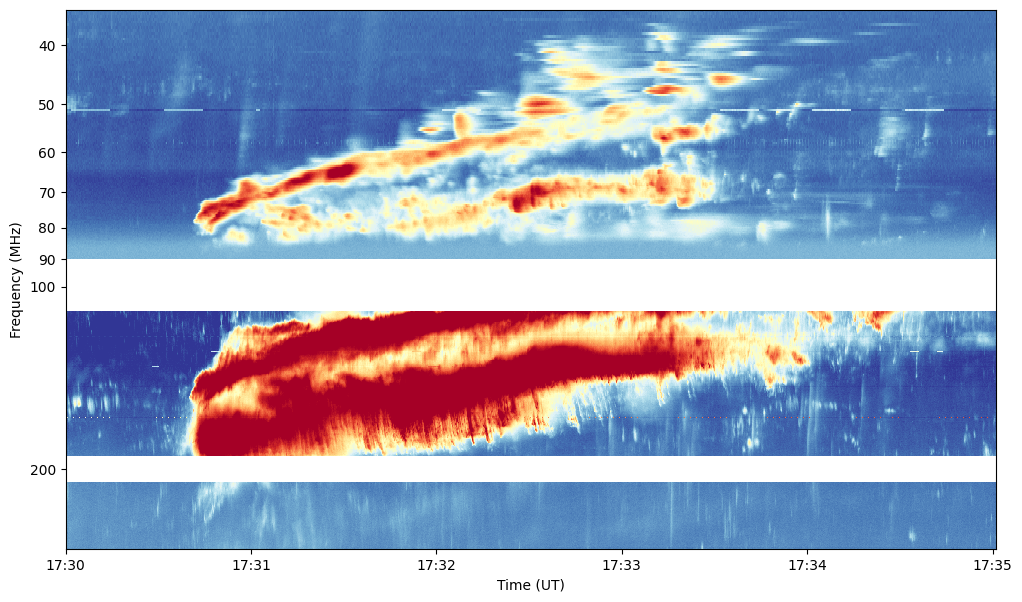

In [14]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3.index, typeII_1_mode3.columns, typeII_1_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5.index, typeII_1_mode5.columns, typeII_1_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7.index, typeII_1_mode7.columns, typeII_1_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

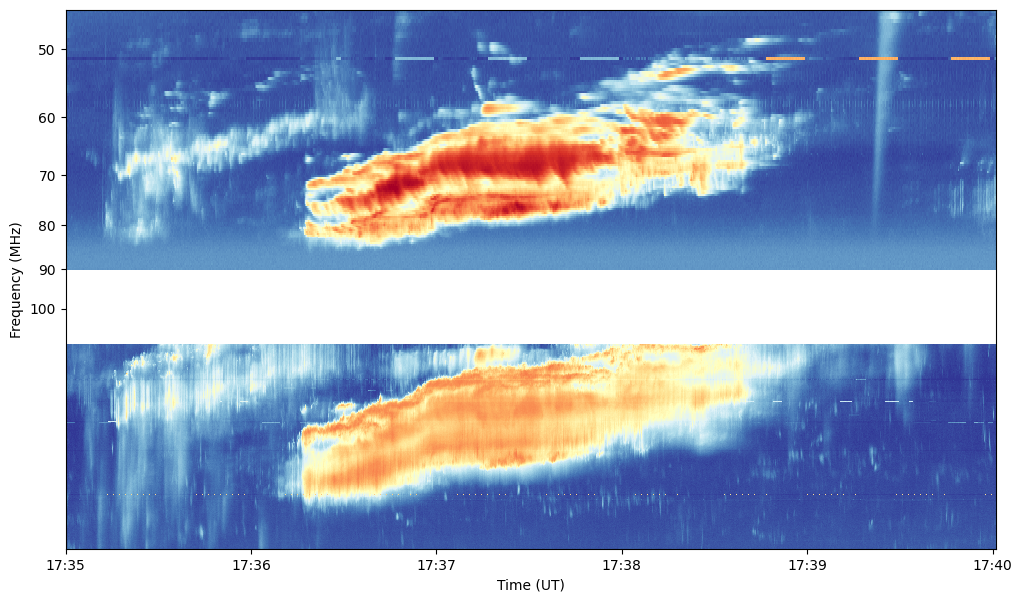

In [13]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3.index, typeII_2_mode3.columns, typeII_2_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5.index, typeII_2_mode5.columns, typeII_2_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7.index, typeII_2_mode7.columns, typeII_2_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)
plt.show()

In [ ]:
min_range = -0.5
max_range = 2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3.index, typeII_3_mode3.columns, typeII_3_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5.index, typeII_3_mode5.columns, typeII_3_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7.index, typeII_3_mode7.columns, typeII_3_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)
plt.show()

## Clicking ...

In [15]:
import matplotlib
matplotlib.use('nbAgg')

In [13]:
# downsampling the data to 1-s resolution for better performance
typeII_1_mode3_1s = typeII_1_mode3.resample('1S').mean()
typeII_1_mode5_1s = typeII_1_mode5.resample('1S').mean()
typeII_1_mode7_1s = typeII_1_mode7.resample('1S').mean()

typeII_2_mode3_1s = typeII_2_mode3.resample('1S').mean()
typeII_2_mode5_1s = typeII_2_mode5.resample('1S').mean()
typeII_2_mode7_1s = typeII_2_mode7.resample('1S').mean()

typeII_3_mode3_1s = typeII_3_mode3.resample('1S').mean()
typeII_3_mode5_1s = typeII_3_mode5.resample('1S').mean()
typeII_3_mode7_1s = typeII_3_mode7.resample('1S').mean()

## Auto-tracing of type IIs

In [222]:
def draw_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0], t_values=None):
    """
    Draw a Bezier curve using the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    A = np.array([x2, y2])
    B = np.array(control)
    C = np.array([x1, y1])

    A = A.reshape(2,1)
    B = B.reshape(2,1)
    C = C.reshape(2,1)

    t = t_values.reshape(1, -1)

    P0 = A * t + (1 - t) * B
    P1 = B * t + (1 - t) * C
    Pfinal = P0 * t + (1 - t) * P1

    return Pfinal

def extract_bezier_values(array, x1, y1, x2, y2, control):
    Pfinal = draw_bezier(x1, y1, x2, y2, control)
    x_coords = np.round(Pfinal[0, :]).astype(int)
    y_coords = np.round(Pfinal[1, :]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords

In [63]:
print(typeII_1_mode3_1s.columns[0], typeII_1_mode3_1s.columns[-1])
print(typeII_1_mode5_1s.columns[0], typeII_1_mode5_1s.columns[-1])
print(typeII_1_mode7_1s.columns[0], typeII_1_mode7_1s.columns[-1])

90.0 10.0
190.0 110.0
270.0 210.0


In [65]:
print(typeII_1_mode3_1s.columns[1] - typeII_1_mode3_1s.columns[0])
print(typeII_1_mode5_1s.columns[1] - typeII_1_mode5_1s.columns[0])
print(typeII_1_mode7_1s.columns[1] - typeII_1_mode7_1s.columns[0])

-0.4040404040404013
-0.40201005025124914
-0.6896551724137794


In [88]:
mode3_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode3_1s.columns)))
mode5_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode5_1s.columns)))
mode7_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode7_1s.columns)))

print(mode3_freq_cadence)
print(mode5_freq_cadence)
print(mode7_freq_cadence)

0.4040404040404013
0.40201005025124914
0.6896551724137794


In [92]:
# Generate a list of numbers with the specified cadence
print(np.arange(90, 110+mode3_freq_cadence, mode3_freq_cadence))

[ 90.          90.4040404   90.80808081  91.21212121  91.61616162
  92.02020202  92.42424242  92.82828283  93.23232323  93.63636364
  94.04040404  94.44444444  94.84848485  95.25252525  95.65656566
  96.06060606  96.46464646  96.86868687  97.27272727  97.67676768
  98.08080808  98.48484848  98.88888889  99.29292929  99.6969697
 100.1010101  100.50505051 100.90909091 101.31313131 101.71717172
 102.12121212 102.52525253 102.92929293 103.33333333 103.73737374
 104.14141414 104.54545455 104.94949495 105.35353535 105.75757576
 106.16161616 106.56565657 106.96969697 107.37373737 107.77777778
 108.18181818 108.58585859 108.98989899 109.39393939 109.7979798
 110.2020202 ]


In [93]:
print(np.arange(190, 210+mode5_freq_cadence, mode5_freq_cadence))

[190.         190.40201005 190.8040201  191.20603015 191.6080402
 192.01005025 192.4120603  192.81407035 193.2160804  193.61809045
 194.0201005  194.42211055 194.8241206  195.22613065 195.6281407
 196.03015075 196.4321608  196.83417085 197.2361809  197.63819095
 198.04020101 198.44221106 198.84422111 199.24623116 199.64824121
 200.05025126 200.45226131 200.85427136 201.25628141 201.65829146
 202.06030151 202.46231156 202.86432161 203.26633166 203.66834171
 204.07035176 204.47236181 204.87437186 205.27638191 205.67839196
 206.08040201 206.48241206 206.88442211 207.28643216 207.68844221
 208.09045226 208.49246231 208.89447236 209.29648241 209.69849246
 210.10050251]


In [123]:
gap1_freqs = np.arange(90+mode3_freq_cadence, 110+mode3_freq_cadence, mode3_freq_cadence)
df_gap1 = pd.DataFrame(index=typeII_1_mode3_1s.index, columns=gap1_freqs)

gap2_freqs = np.arange(190+mode5_freq_cadence, 210+mode5_freq_cadence, mode5_freq_cadence)
df_gap2 = pd.DataFrame(index=typeII_1_mode3_1s.index, columns=gap2_freqs)

In [134]:
# Concatenate along columns axis
combined_df = pd.concat([typeII_1_mode3_1s, df_gap1, typeII_1_mode5_1s, df_gap2, typeII_1_mode7_1s], axis=1)
combined_df.index = mdates.date2num(combined_df.index)

# Sort columns numerically
combined_df = combined_df.reindex(sorted(combined_df.columns.astype('float')), axis=1).astype('float64')

In [250]:
min_range = -0.5
max_range = 3

## Define start and end points and control point for the Bézier curve

# Given timestamp to find the nearest index
given_timestamp_x1 = mdates.date2num(pd.Timestamp('2024-05-14 17:30:40'))
given_timestamp_x2 = mdates.date2num(pd.Timestamp('2024-05-14 17:33:30'))

# Find the nearest index
nearest_index_x1 = combined_df.index.get_loc(given_timestamp_x1)
nearest_index_x2 = combined_df.index.get_loc(given_timestamp_x2)

# x1 = combined_df.index[nearest_index_x1]
# x2 = combined_df.index[nearest_index_x2]

x1 = 0.0296+1.98577e4
x2 = 0.0316+1.98577e4

# Given number to find the nearest index
given_freq_y1 = 200
given_freq_y2 = 120

# Calculate differences
differences1 = np.abs(combined_df.columns - given_freq_y1)
differences2 = np.abs(combined_df.columns - given_freq_y2)

# Find the nearest index
nearest_index_y1 = differences1.argmin()
nearest_index_y2 = differences2.argmin()

y1 = combined_df.columns[nearest_index_y1]
y2 = combined_df.columns[nearest_index_y2]

control = [10, 10]



fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(combined_df.index, combined_df.columns, combined_df.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')

# Extract values along the Bézier curve
# bezier_values, x_coords, y_coords = extract_bezier_values(combined_df.values.T, x1, y1, x2, y2, control)
# ax.plot(x_coords, y_coords, 'ko--', linewidth=2)


# Generate t values based on the timestamps
# t_values = np.arange(0, 1, 0.05)
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control, t_values=t_values)
ax.plot(Pfinal[0,:], Pfinal[1,:], 'ko--', linewidth=2)

# ax.scatter(mdates.date2num(pd.Timestamp('2024-05-14 17:31:00')), 180, c='k')

ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
print(ax.get_xlim())
print(ax.get_ylim())
plt.show()

(19857.73264467593, 16434920179430.992)
(377743004564.46, 35.0)


OverflowError: int too big to convert

<Figure size 1000x600 with 1 Axes>

In [230]:
x1, x2

(19857.729600000002, 19857.7316)

In [231]:
y1, y2

(200.05025125628123, 120.05025125628141)

In [251]:
Pfinal

array([[1.56522995e+13, 1.56522995e+13, 1.56522995e+13, 1.56522995e+13,
        1.56522995e+13, 1.56522996e+13, 1.56522996e+13, 1.56522996e+13,
        1.56522996e+13, 1.56522996e+13, 1.56522996e+13, 1.56522997e+13,
        1.56522997e+13, 1.56522997e+13, 1.56522997e+13, 1.56522997e+13,
        1.56522998e+13, 1.56522998e+13, 1.56522998e+13, 1.56522998e+13,
        1.56522998e+13, 1.56522998e+13, 1.56522999e+13, 1.56522999e+13,
        1.56522999e+13, 1.56522999e+13, 1.56522999e+13, 1.56523000e+13,
        1.56523000e+13, 1.56523000e+13, 1.56523000e+13, 1.56523000e+13,
        1.56523000e+13, 1.56523001e+13, 1.56523001e+13, 1.56523001e+13,
        1.56523001e+13, 1.56523001e+13, 1.56523002e+13, 1.56523002e+13,
        1.56523002e+13, 1.56523002e+13, 1.56523002e+13, 1.56523002e+13,
        1.56523003e+13, 1.56523003e+13, 1.56523003e+13, 1.56523003e+13,
        1.56523003e+13, 1.56523004e+13, 1.56523004e+13, 1.56523004e+13,
        1.56523004e+13, 1.56523004e+13, 1.56523004e+13, 1.565230

In [247]:
pd.date_range('2024-05-14 17:00', periods=100, freq='T')

DatetimeIndex(['2024-05-14 17:00:00', '2024-05-14 17:01:00',
               '2024-05-14 17:02:00', '2024-05-14 17:03:00',
               '2024-05-14 17:04:00', '2024-05-14 17:05:00',
               '2024-05-14 17:06:00', '2024-05-14 17:07:00',
               '2024-05-14 17:08:00', '2024-05-14 17:09:00',
               '2024-05-14 17:10:00', '2024-05-14 17:11:00',
               '2024-05-14 17:12:00', '2024-05-14 17:13:00',
               '2024-05-14 17:14:00', '2024-05-14 17:15:00',
               '2024-05-14 17:16:00', '2024-05-14 17:17:00',
               '2024-05-14 17:18:00', '2024-05-14 17:19:00',
               '2024-05-14 17:20:00', '2024-05-14 17:21:00',
               '2024-05-14 17:22:00', '2024-05-14 17:23:00',
               '2024-05-14 17:24:00', '2024-05-14 17:25:00',
               '2024-05-14 17:26:00', '2024-05-14 17:27:00',
               '2024-05-14 17:28:00', '2024-05-14 17:29:00',
               '2024-05-14 17:30:00', '2024-05-14 17:31:00',
               '2024-05-

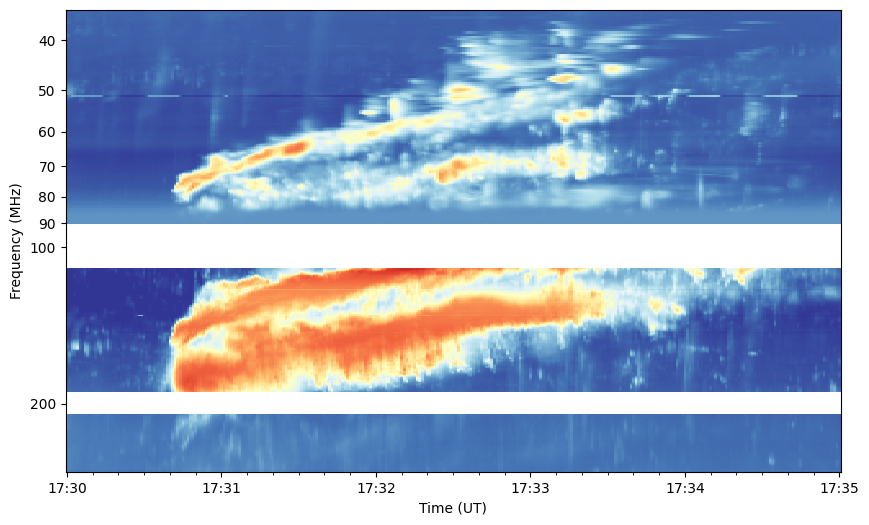

In [61]:
min_range = -0.5
max_range = 3

## Define start and end points and control point for the Bézier curve

# Given timestamp to find the nearest index
given_timestamp_x1 = pd.Timestamp('2024-05-14 17:30:40')
given_timestamp_x2 = pd.Timestamp('2024-05-14 17:33:30')

# Find the nearest index
nearest_index_x1 = typeII_1_mode3_1s.index.get_loc(given_timestamp_x1)
nearest_index_x2 = typeII_1_mode3_1s.index.get_loc(given_timestamp_x2)

x1 = mdates.date2num(typeII_1_mode3_1s.index[nearest_index_x1])
x2 = mdates.date2num(typeII_1_mode3_1s.index[nearest_index_x2])

# Given number to find the nearest index
given_freq_y1 = 200
given_freq_y2 = 120

# Calculate differences
differences1 = np.abs(typeII_1_mode3_1s.columns - given_freq_y1)
differences2 = np.abs(typeII_1_mode3_1s.columns - given_freq_y2)

# Find the nearest index
nearest_index_y1 = differences1.argmin()
nearest_index_y2 = differences2.argmin()

y1 = typeII_1_mode3_1s.columns[nearest_index_y1]
y2 = typeII_1_mode3_1s.columns[nearest_index_y2]

control = [0, 1]

# Extract values along the Bézier curve
bezier_values, x_coords, y_coords = extract_bezier_values(typeII_1_mode5_1s.values.T, x1, y1, x2, y2, control)


fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3_1s.index, typeII_1_mode3_1s.columns, typeII_1_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5_1s.index, typeII_1_mode5_1s.columns, typeII_1_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7_1s.index, typeII_1_mode7_1s.columns, typeII_1_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')

# plt.plot(x_coords, y_coords, 'ko--', linewidth=2)

ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

In [55]:
y1, y2

(90.0, 90.0)

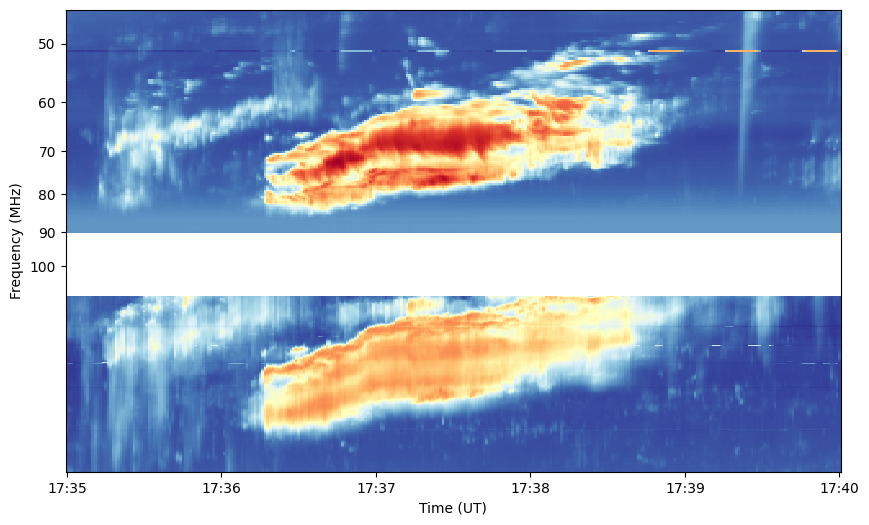

In [17]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3_1s.index, typeII_2_mode3_1s.columns, typeII_2_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5_1s.index, typeII_2_mode5_1s.columns, typeII_2_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7_1s.index, typeII_2_mode7_1s.columns, typeII_2_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)
plt.show()

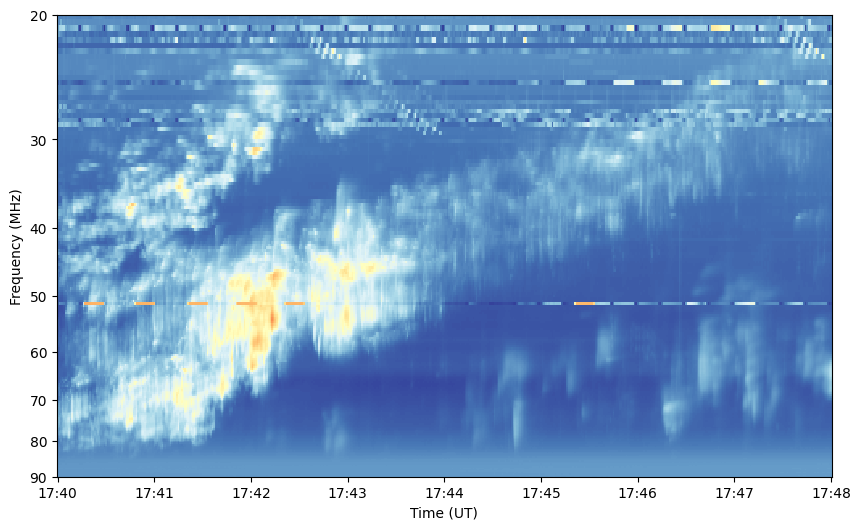

In [18]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3_1s.index, typeII_3_mode3_1s.columns, typeII_3_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5_1s.index, typeII_3_mode5_1s.columns, typeII_3_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7_1s.index, typeII_3_mode7_1s.columns, typeII_3_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)
plt.show()

<IPython.core.display.Javascript object>


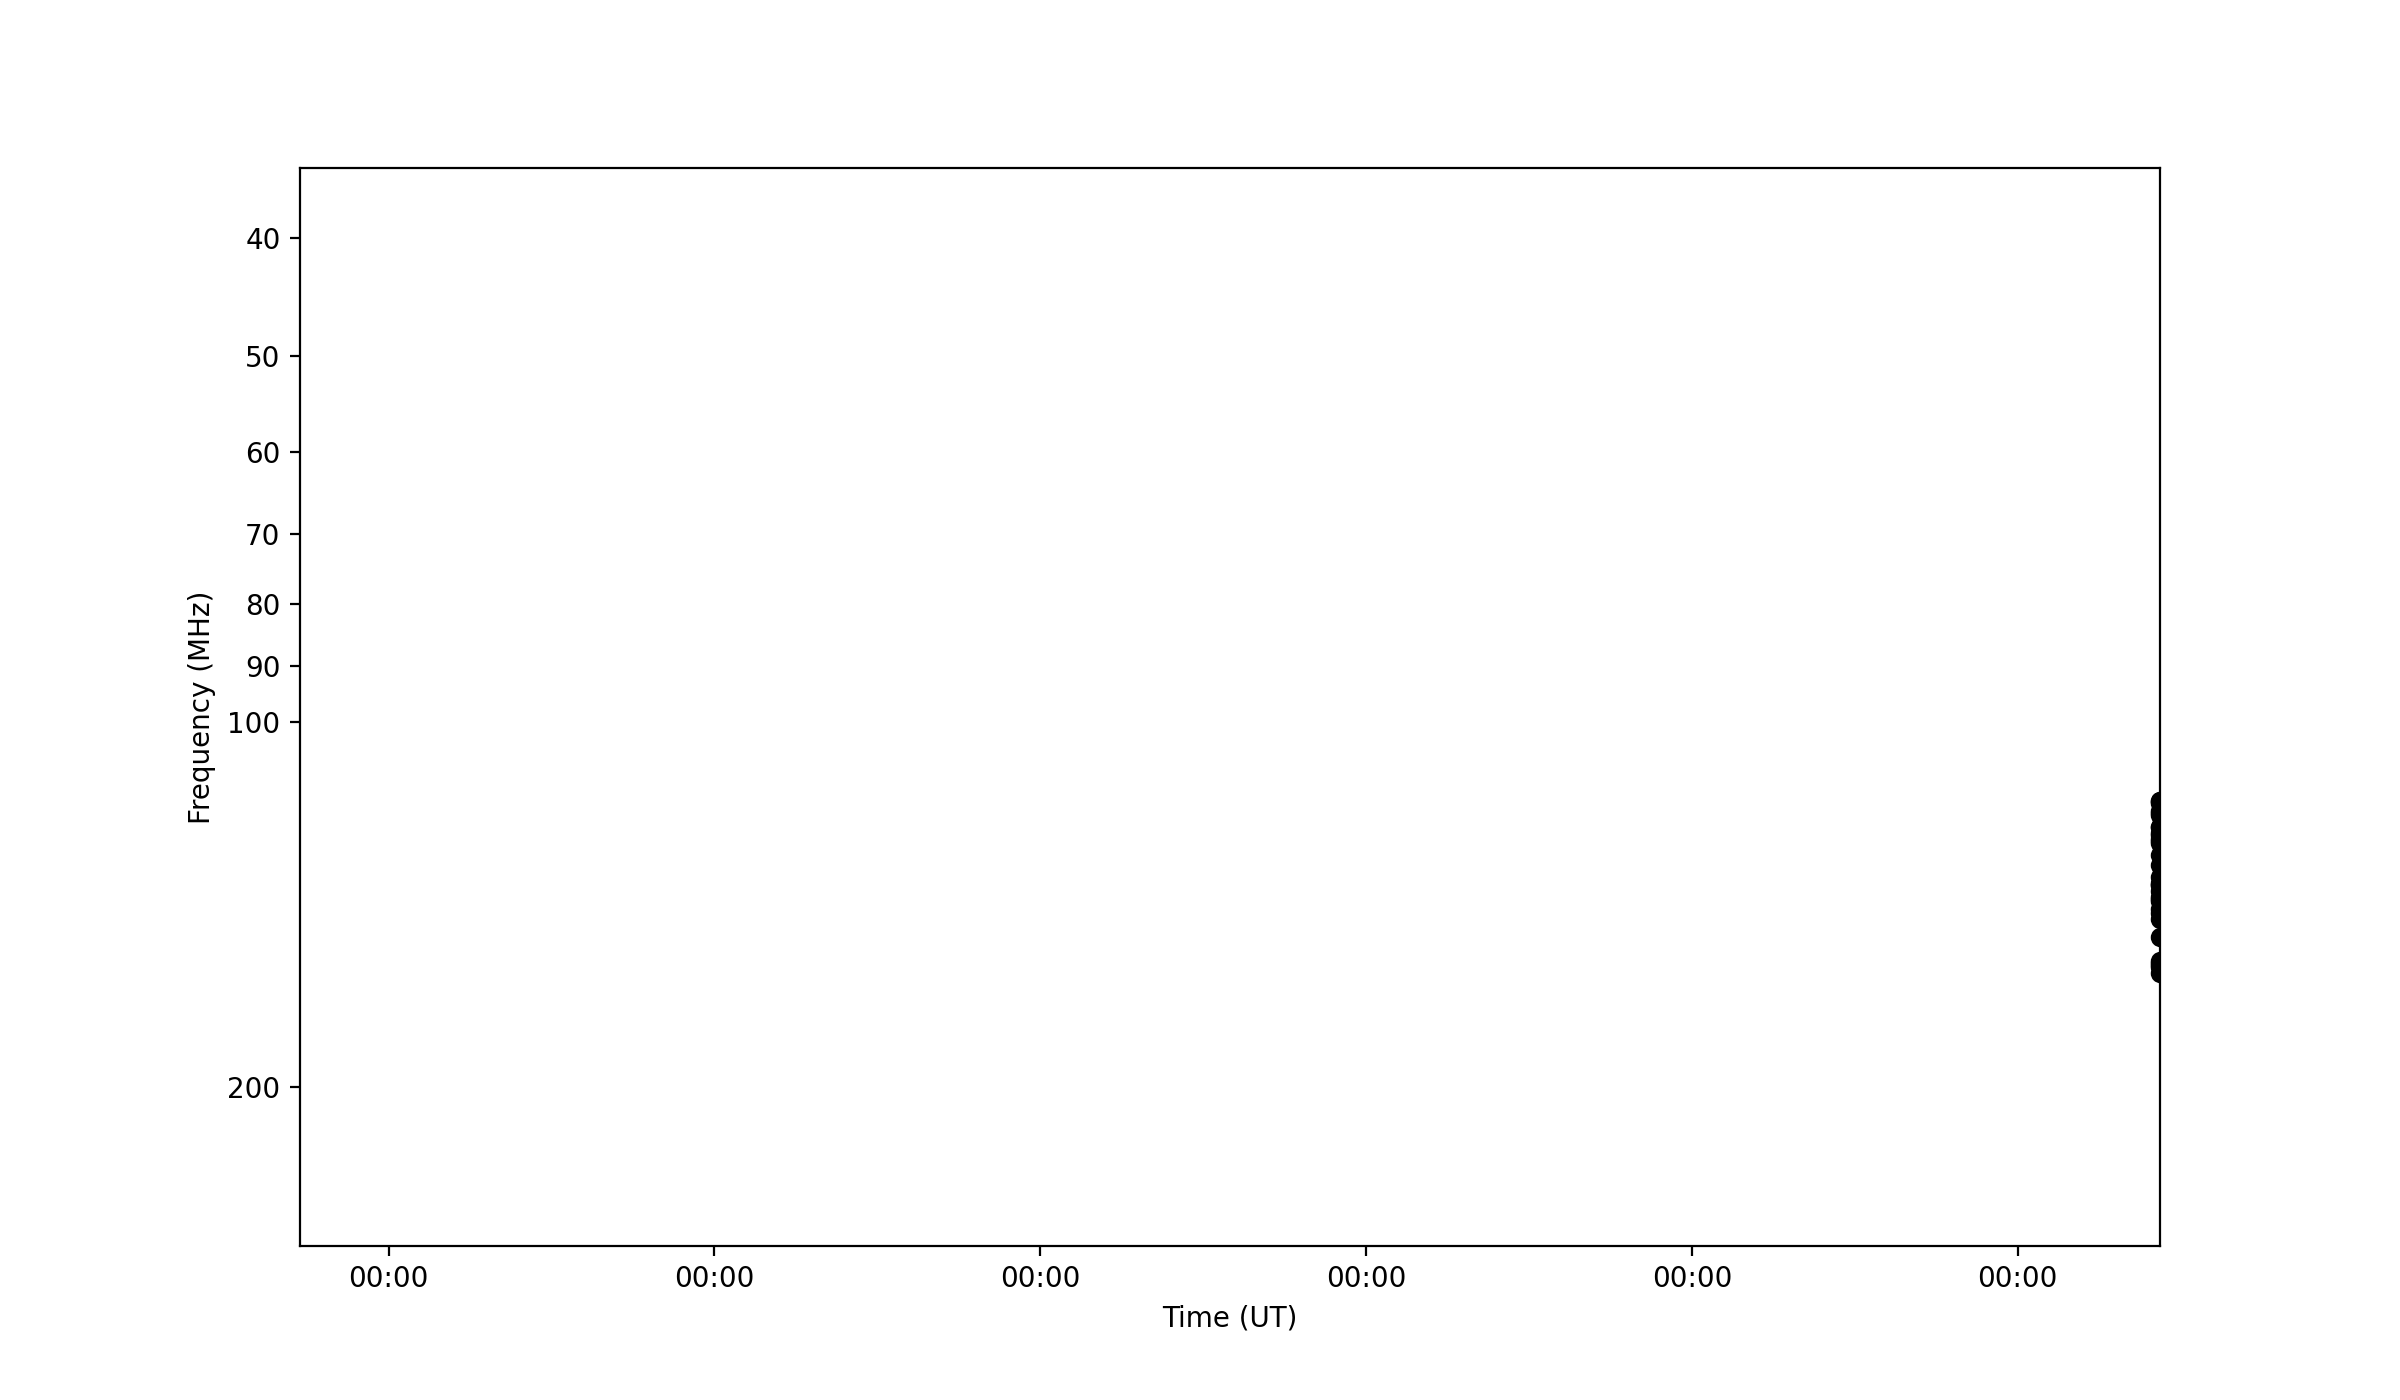

In [22]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3_1s.index, typeII_1_mode3_1s.columns, typeII_1_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5_1s.index, typeII_1_mode5_1s.columns, typeII_1_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7_1s.index, typeII_1_mode7_1s.columns, typeII_1_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)

# List to store coordinates
typeII_1_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_1_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [24]:
df_typeII_1_f_t = pd.DataFrame(typeII_1_f_t_points, columns=['time','frequency'])
df_typeII_1_f_t.head()

,time,frequency
0,19857.729661,161.210993
1,19857.729721,158.182548
2,19857.729777,159.387038
3,19857.729826,158.783651
4,19857.729878,157.583720


In [44]:
from scipy.optimize import fsolve

In [45]:
def freq_to_n(fpe):
    """
    Calculate electron density [cm-3] from plasma frequency [Hz].
    """
    ne = (fpe / (8.89*10**3))**2
    return ne


def newkirk_h(r):
    """
    Newkirk electron-density model.
    fold: is a multiplicative factor to change the density scaling.
    """
    fold = 2.5
    model = fold*4.2e4*10**(4.32/r)
    return model


def invert_newkirk_h(ne):
    """
    Invert the Newkirk electron-density model to find the radial distance
    for a given electron density.
    """
    def equation(r):
        # Define the equation for which we need to find the root.
        # It returns the difference between the model's density and the given density.
        return newkirk_h(r) - ne

    # Initial guess for the radial distance can be set to a reasonable value.
    r_guess = 1.0
    
    # Use fsolve to find the root of the equation, which is the radial distance r
    # that makes the equation zero.
    r_solution, = fsolve(equation, r_guess)
    return r_solution

In [46]:
# Convert frequencies to electron densities
ne_typeII_1 = freq_to_n(df_typeII_1_f_t['frequency'].values*10**6)

In [47]:
ne_typeII_1

array([3.28840865e+08, 3.16601968e+08, 3.21441895e+08, 3.19012753e+08,
       3.14209402e+08, 2.86870550e+08, 2.67939078e+08, 2.57966842e+08,
       2.61910407e+08, 2.50256952e+08, 2.48365756e+08, 2.46488852e+08,
       2.33741724e+08, 2.35521564e+08, 2.40942814e+08, 2.35521564e+08,
       2.28482499e+08, 2.18316386e+08, 2.10191023e+08, 1.99321030e+08,
       1.89013178e+08, 1.89013178e+08, 1.94836276e+08, 1.97814758e+08,
       2.00838772e+08, 1.93363896e+08, 1.80603216e+08, 1.71263352e+08,
       1.71263352e+08, 1.72567447e+08, 1.77883887e+08, 1.79238394e+08])

In [50]:
# Convert electron densities to radial distances
r_typeII_1 = [invert_newkirk_h(ne) for ne in ne_typeII_1]

<IPython.core.display.Javascript object>


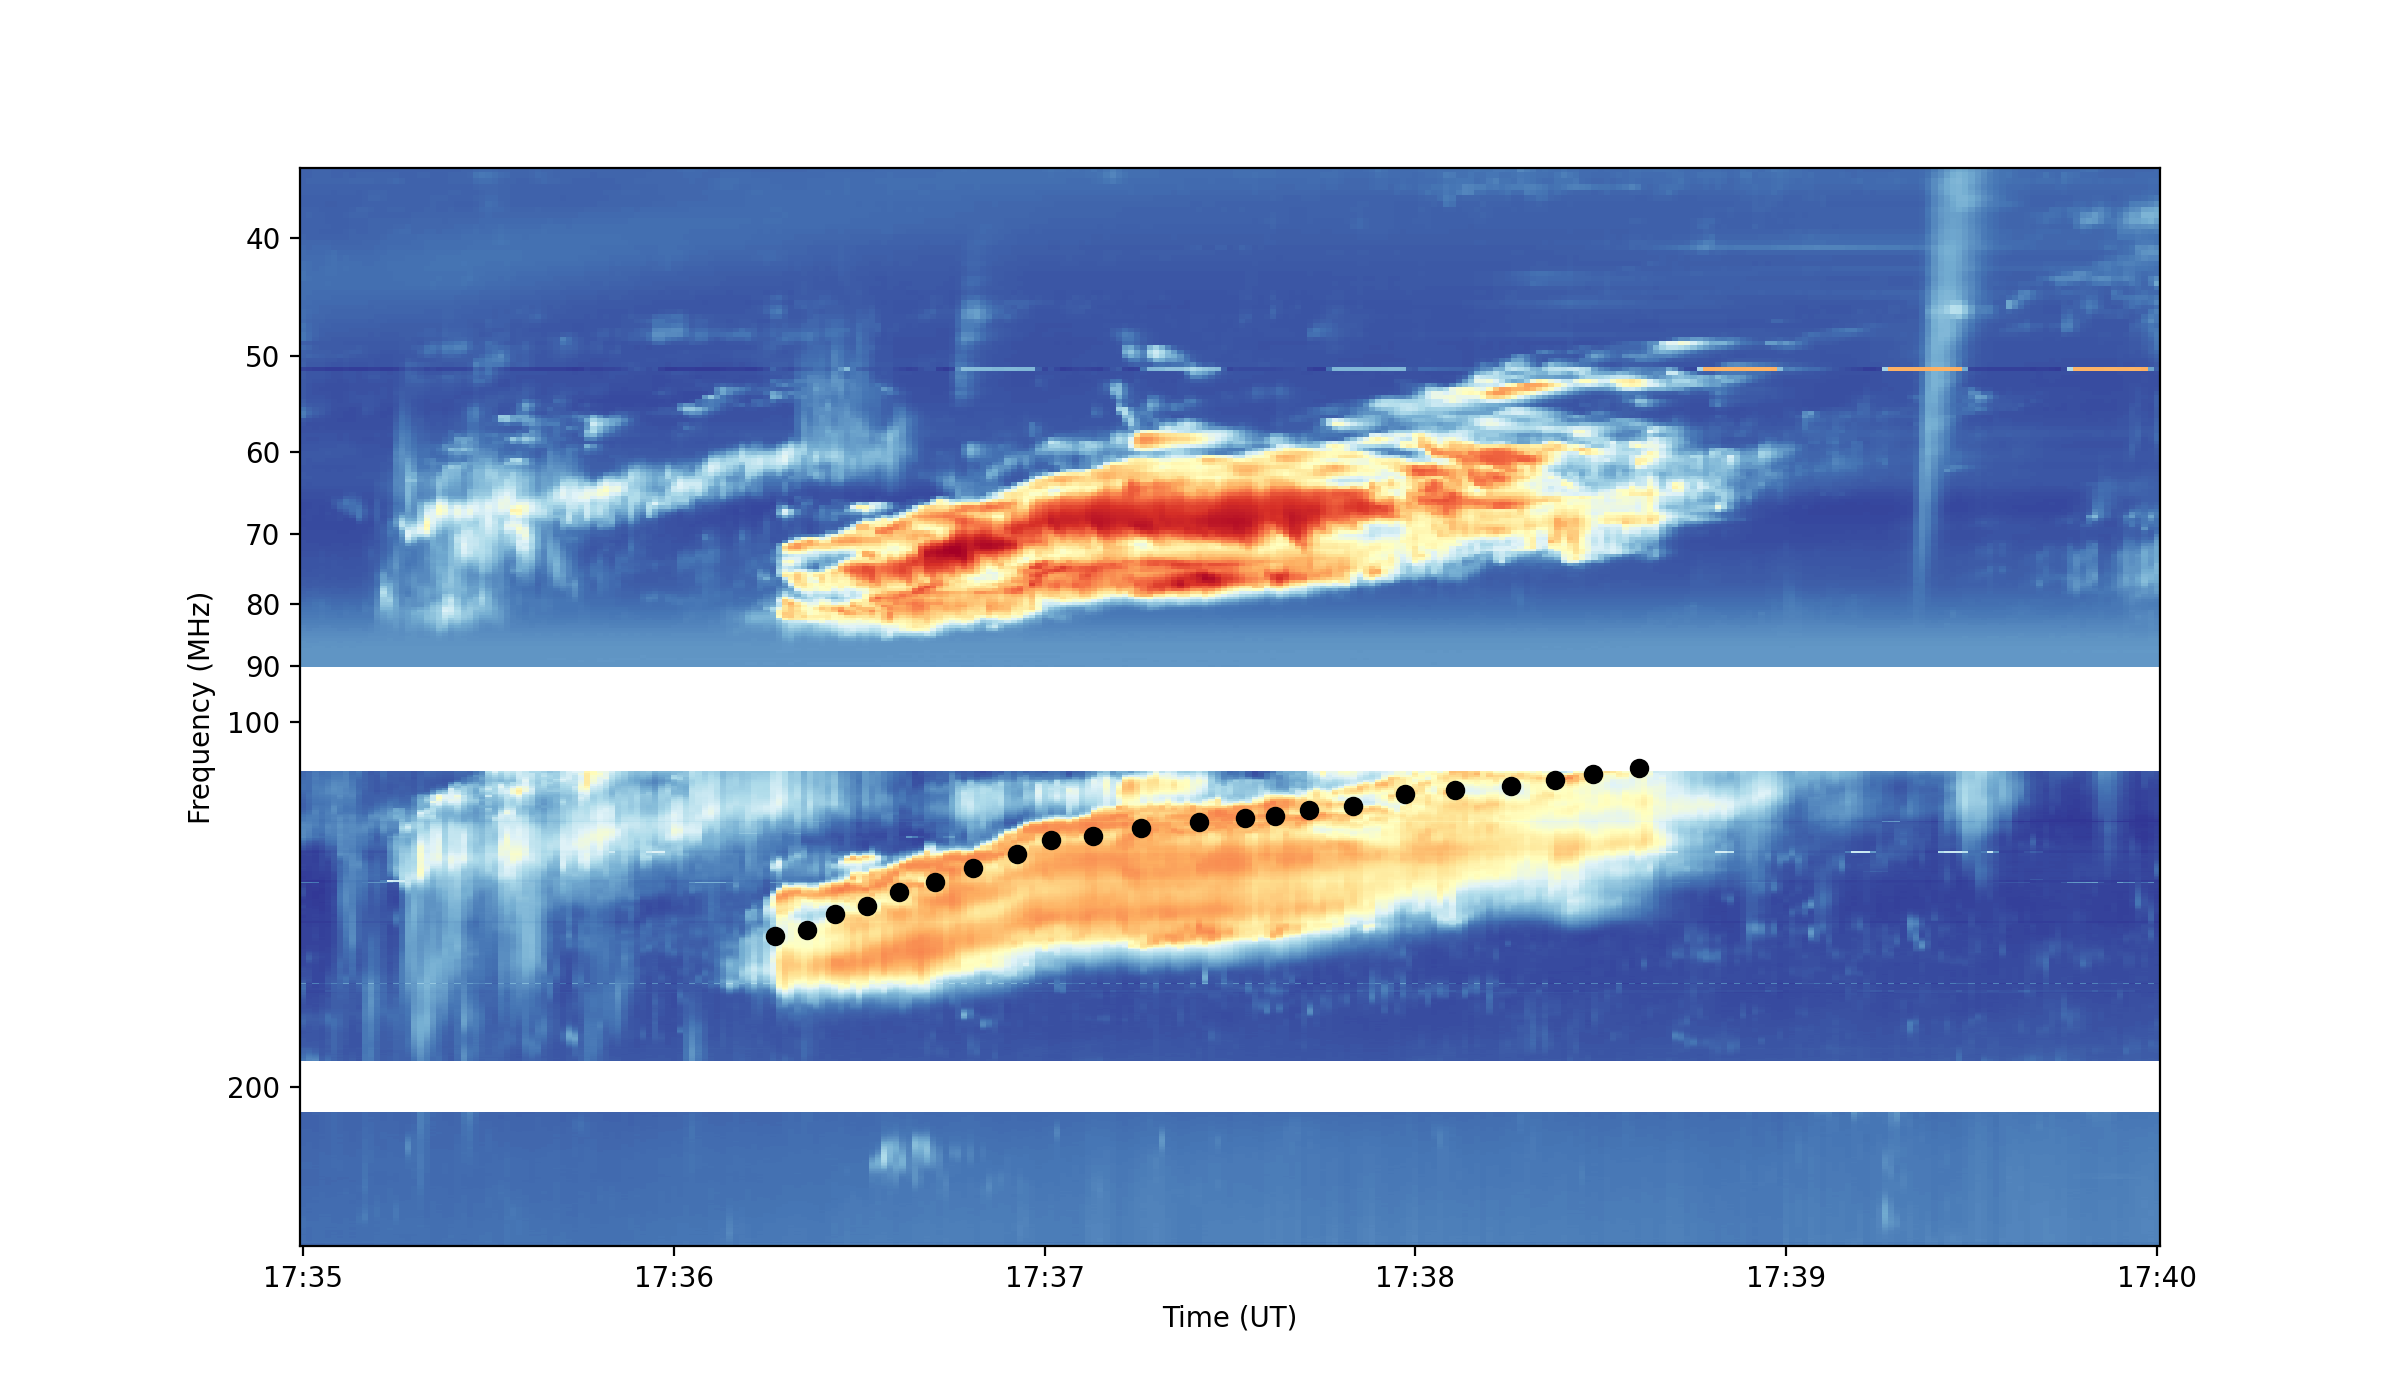

In [52]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3_1s.index, typeII_2_mode3_1s.columns, typeII_2_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5_1s.index, typeII_2_mode5_1s.columns, typeII_2_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7_1s.index, typeII_2_mode7_1s.columns, typeII_2_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)

# List to store coordinates
typeII_2_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_2_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [54]:
df_typeII_2_f_t = pd.DataFrame(typeII_2_f_t_points, columns=['time','frequency'])
df_typeII_2_f_t.head()

,time,frequency
0,19857.733523,150.171163
1,19857.733583,148.472114
2,19857.733635,144.034708
3,19857.733695,141.865988
4,19857.733755,138.149007


In [55]:
# Convert frequencies to electron densities
ne_typeII_2 = freq_to_n(df_typeII_2_f_t['frequency'].values*10**6)

# Convert electron densities to radial distances
r_typeII_2 = [invert_newkirk_h(ne) for ne in ne_typeII_2]

<IPython.core.display.Javascript object>


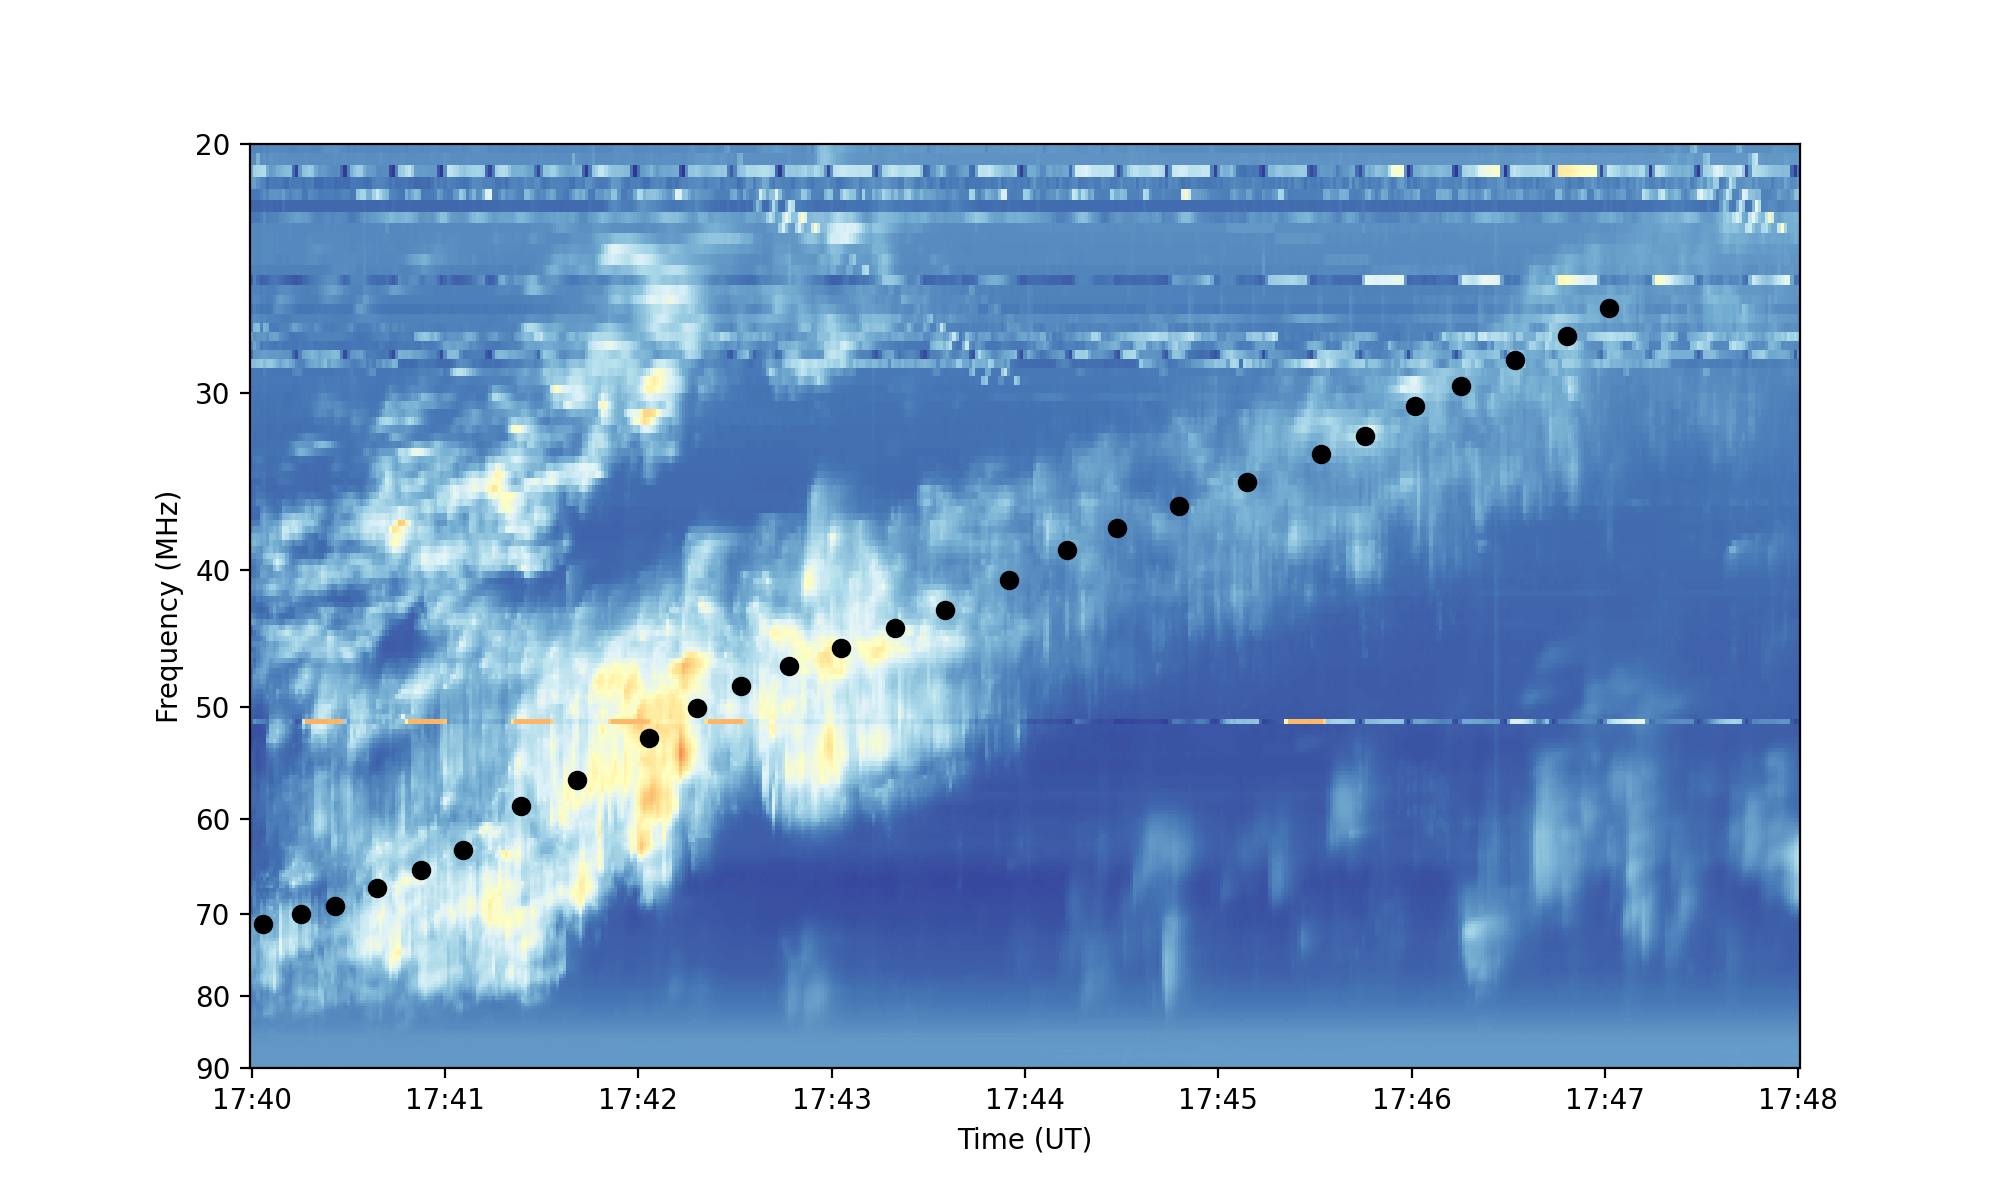

In [58]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3_1s.index, typeII_3_mode3_1s.columns, typeII_3_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5_1s.index, typeII_3_mode5_1s.columns, typeII_3_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7_1s.index, typeII_3_mode7_1s.columns, typeII_3_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)

# List to store coordinates
typeII_3_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_3_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [59]:
df_typeII_3_f_t = pd.DataFrame(typeII_3_f_t_points, columns=['time','frequency'])
df_typeII_3_f_t.head()

,time,frequency
0,19857.736152,71.246493
1,19857.736289,70.096138
2,19857.736411,69.189242
3,19857.736562,67.191394
4,19857.736720,65.251234


In [61]:
# Convert frequencies to electron densities
ne_typeII_3 = freq_to_n(df_typeII_3_f_t['frequency'].values*10**6)

# Convert electron densities to radial distances
r_typeII_3 = [invert_newkirk_h(ne) for ne in ne_typeII_3]

In [78]:
# Ensure all arrays are converted to lists
data = {
    'time_typeII_1': df_typeII_1_f_t['time'].tolist(),
    'freq_typeII_1': df_typeII_1_f_t['frequency'].tolist(),
    'ne_typeII_1': list(ne_typeII_1),
    'r_typeII_1': list(r_typeII_1),
    
    'time_typeII_2': df_typeII_2_f_t['time'].tolist(),
    'freq_typeII_2': df_typeII_2_f_t['frequency'].tolist(),
    'ne_typeII_2': list(ne_typeII_2),
    'r_typeII_2': list(r_typeII_2),
    
    'time_typeII_3': df_typeII_3_f_t['time'].tolist(),
    'freq_typeII_3': df_typeII_3_f_t['frequency'].tolist(),
    'ne_typeII_3': list(ne_typeII_3),
    'r_typeII_3': list(r_typeII_3)
}

# Find the maximum length
max_len = max(len(lst) for lst in data.values())

# Extend each list with None to the maximum length
for key in data:
    data[key] += [None] * (max_len - len(data[key]))

# Create the DataFrame and save it to a CSV file
df_data = pd.DataFrame(data)
df_data.to_csv('./newkirk_typeIIs.csv', index=False)

In [81]:
df_data.head()

,time_typeII_1,freq_typeII_1,ne_typeII_1,r_typeII_1,time_typeII_2,freq_typeII_2,ne_typeII_2,r_typeII_2,time_typeII_3,freq_typeII_3,ne_typeII_3,r_typeII_3
0,19857.729661,161.210993,3.288409e+08,1.235770,19857.733523,150.171163,2.853445e+08,1.257942,19857.736152,71.246493,6.422786e+07,1.550313
1,19857.729721,158.182548,3.166020e+08,1.241620,19857.733583,148.472114,2.789242e+08,1.261573,19857.736289,70.096138,6.217054e+07,1.558219
2,19857.729777,159.387038,3.214419e+08,1.239274,19857.733635,144.034708,2.625009e+08,1.271358,19857.736411,69.189242,6.057224e+07,1.564603
3,19857.729826,158.783651,3.190128e+08,1.240446,19857.733695,141.865988,2.546555e+08,1.276308,19857.736562,67.191394,5.712468e+07,1.579158
4,19857.729878,157.583720,3.142094e+08,1.242797,19857.733755,138.149007,2.414860e+08,1.285063,19857.736720,65.251234,5.387334e+07,1.593987
